This code is from the Github repository of Kevin Systrom at https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb. In this notebook, he essentially developed a bayesian estimate method for the basic reproductive number for COVID cases by day using a Poisson likelihood.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Data
I prepared the data in R since I already was working on the data in that environment.

In [2]:
file_path = "data/bw-smc-combined.csv"
states = pd.read_csv(file_path,
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()
states

state  date      
BW     2020-02-25      1
       2020-02-26      4
       2020-02-27      8
       2020-02-28     14
       2020-02-29     15
                    ... 
SMC    2020-04-07    103
       2020-04-10    104
       2020-04-13    108
       2020-04-14    109
       2020-04-29    110
Name: count, Length: 96, dtype: int64

## Functions needed to conduct the analysis, see the above iPython Notebook for explanations.

In [3]:
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed


In [4]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

In [5]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

In [6]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

In [7]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

## Run the model and print results

In [8]:
results = {}

states_to_process = states.loc[states.index.get_level_values('state')]

for state_name, cases in states_to_process.groupby(level='state'):
    clear_output(wait=True)
    print(f'Processing {state_name}')
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[state_name] = result.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


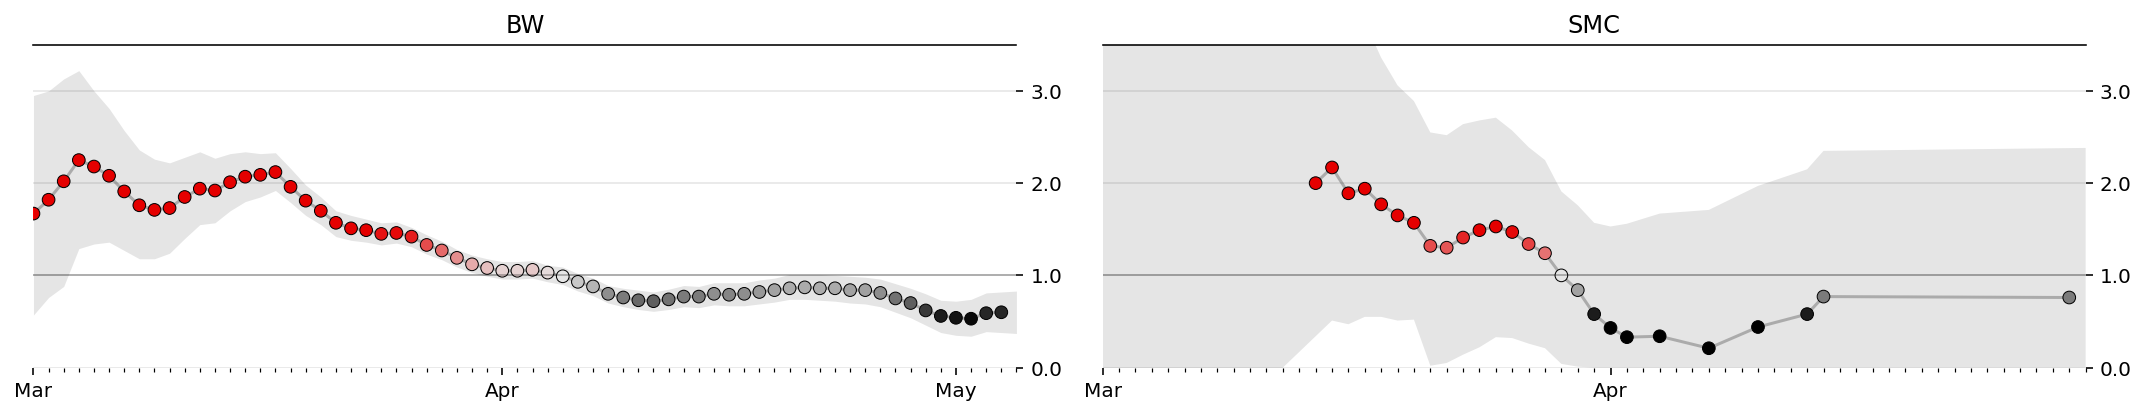

In [9]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')